# G06. GO STOP! - Object Detection 시스템 만들기

## 들어가며

![GC-4-P-jan-kronies.max-800x600.jpg](Going_img/GC-4-P-jan-kronies.max-800x600.jpg)

<center>https://unsplash.com/photos/mpSeLIXMnpc</center>

이번 시간에는 object detection 모델을 통해 주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어 보겠습니다. 하지만 자율주행 시스템은 아직 완전하지 않기 때문에, 위험한 상황에서는 운전자가 직접 운전할 수 있도록 하거나 판단이 어려운 상황에서는 멈추도록 설계됩니다. 우리도 같은 구조를 가진 미니 자율주행 시스템을 만들어 볼 겁니다.

먼저 전체적인 시스템을 구성하기 위해서 보조장치의 역할과 이를 학습하기 위한 데이터셋 전처리를 수행하겠습니다. Detection 모델을 학습시키기 위한 전체 파이프라인을 직접 제작하기에는 많은 시간이 들기 때문에 RetinaNet이라는 1-stage detector를 미리 학습시킨 라이브러리를 활용하도록 하겠습니다.

>주의: 이번 노드는 학습데이터 다운로드에 시간이 매우 오래 걸립니다. 학습하실 때 적절히 시간을 분배해 주세요.

## 실습 목표
***
바운딩 박스(bounding box) 데이터셋을 전처리할 수 있습니다.  
Object detection 모델을 학습할 수 있습니다.  
Detection 모델을 활용한 시스템을 만들 수 있습니다.  

## 학습 내용
***
자율주행 보조장치  
RetinaNet  
keras-retinanet  
프로젝트: 자율주행 보조 시스템 만들기  

## 준비물
***
아직 경로를 생성하지 않았다면 터미널을 열고 개인 실습 환경에 따라 경로를 수정, 프로젝트를 위한 디렉토리를 생성해 주세요.

`$ mkdir -p ~/aiffel/object_detection/data`

**(주의) <a href="https://github.com/fizyr/keras-retinanet">RetinaNet 홈페이지**</a> 에 보면 **tensorflow 2.3.0, tf.keras 2.4.0**을 사용할 것을 권장하며, 그보다 높은 버전에서는 오류가 발생한다고 안내하고 있습니다. 만약 `aiffel` 가상환경에 설치된 Tensorflow 버전이 2.3.0보다 높을 경우 2.3.0에 맞추어 재설치하거나,
아니면 별도의 가상환경을 생성 후 해당 환경에서 jupyter notebook으로 실습을 진행할 것을 권합니다.

`$ pip uninstall tensorflow
 $ pip install tensorflow==2.3.0`

프로젝트 디렉토리로 이동합니다. 그 후 다음 리포지토리(repository)를 받고, 리포지토리 사용에 필요한 케라스 라이브러리를 aiffel 가상환경 내에 설치해 줍니다.

`$ cd ~/aiffel/object_detection
 $ git clone https://github.com/fizyr/keras-retinanet.git
 $ cd keras-retinanet && python setup.py build_ext --inplace`

필요사항을 설치하고, `keras-retinanet` 또한 pip 패키지로 인스톨 해줍니다.

`$ pip install tensorflow_datasets tqdm
 $ pip install -r requirements.txt
 $ pip install .`

# 자율주행 보조 시스템 만들기

KITTI데이터셋 분석
---
- [KITTI](http://www.cvlibs.net/datasets/kitti/) 데이터셋은 자율주행을 위한 데이터셋.
- 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공
    - 다음은 제공하는 라벨 정보이다
    ![image](https://user-images.githubusercontent.com/48716219/97407066-7dd8ed00-193d-11eb-9518-0d69ff24892a.png)
- 여기서는 ```tensorflow_dataset```을 활용해서 데이터를 가져옴
    - 처음 설치할 경우 11GB가 넘어가는 대용량의 데이터셋이기 때문에 매우 오래걸림

### 라이브러리 Import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

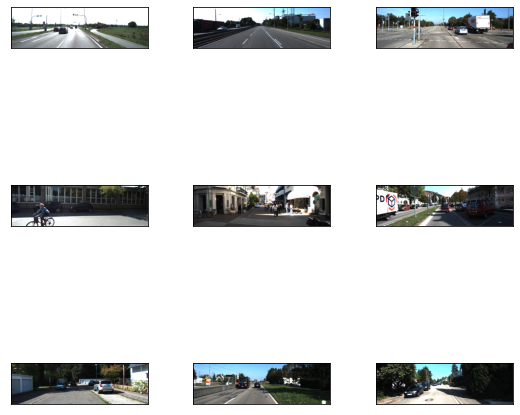

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj56/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

### 데이터 확인해보기
- 확인을 해보면 TakeDataset에 담긴 내용들은 xml 혹은 Json({key : value})과 같은 형태로 정보들이 담겨 있는 것을 확인할 수 있다.

- 실제로 tensorflow_dataset을 통해서 받는 것이 아닌 직접 받아서 확인해보면 각 이미지에 대한  annotation이 담겨있는 xml파일을 확인할 수 있다.
    - xml파싱에 대한 내용은 다음 블로그에서 사용했었다. ([링크](https://blog.naver.com/ab415/222028110136))
    - [AI Hub에서 제공받은 인도 보행 영상](https://aihub.or.kr/aidata/136)의 annotation을 KITTI 데이터셋의 xml 형식

- 여기서 사용할 annotation정보는 이미지의 바운딩 박스 정보를 담은 bbox를 사용할 것이다.
    - ```bbox```에는 4개의 값이 있고 각각 ```left```, ```top```, ```right```, ```bottom``` 의 pixel 정보

In [5]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([ 2.02,  1.17,  1.76,  1.43,  1.68, -1.63, -1.62], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.00266667, 0.00683575, 0.53573334, 0.33022544],
       [0.00266667, 0.6232045 , 0.46514666, 0.99919486],
       [0.32930666, 0.32613528, 0.5345067 , 0.40726247],
       [0.37250668, 0.54978263, 0.52029335, 0.61419487],
       [0.40573335, 0.38175523, 0.5354933 , 0.4366908 ],
       [0.46130666, 0.525153  , 0.53736   , 0.55117553],
       [0.48546666, 0.51616746, 0.57794666, 0.54144925]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.56, 1.68, 3.69],
       [1.44, 1.64, 4.5 ],
       [1.46, 1.51, 3.24],
       [1.38, 1.59, 4.19],
       [1.38, 1.69, 3.74],
       [1.51, 1.56, 3.81],
       [2.38, 1.98, 5.62]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array

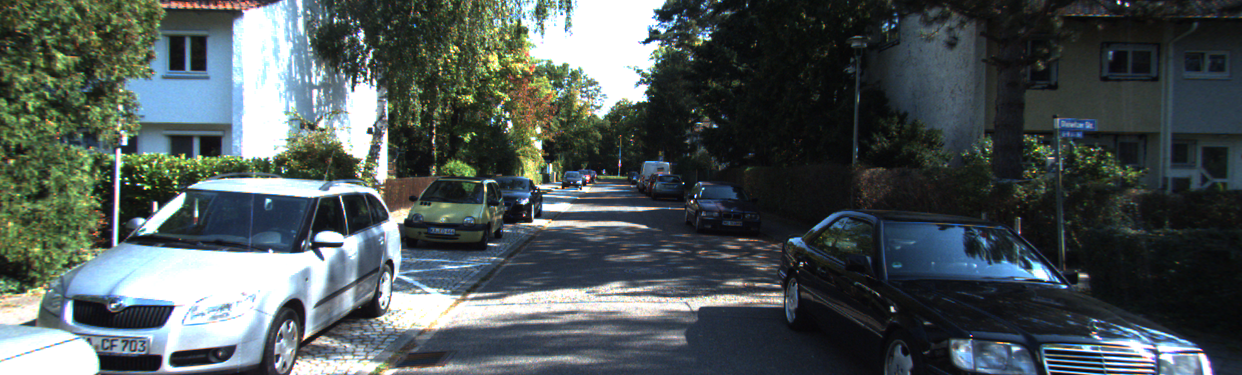

In [6]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

### 이미지에 Bounding Box 시각화

width : 1242, height : 375

이미지 내에 있는 bounding box : 7개
[[   8.49     374.       410.13998  174.09999]
 [ 774.02     374.      1241.       200.57   ]
 [ 405.06003  251.51001  505.82     174.56   ]
 [ 682.83     235.31     762.83     179.89   ]
 [ 474.13998  222.84999  542.37     174.19   ]
 [ 652.24     202.01     684.56     173.48999]
 [ 641.08     192.95     672.48     158.27   ]]
[  8.49    374.      410.13998 174.09999]
[ 774.02  374.   1241.    200.57]
[405.06003 251.51001 505.82    174.56   ]
[682.83 235.31 762.83 179.89]
[474.13998 222.84999 542.37    174.19   ]
[652.24    202.01    684.56    173.48999]
[641.08 192.95 672.48 158.27]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F1A241776D0>


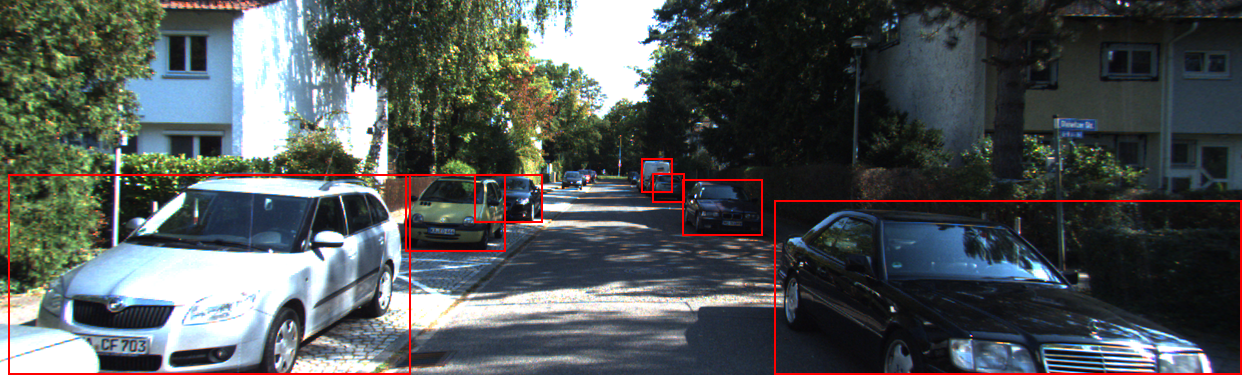

In [7]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

        # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(f'width : {width}, height : {height}')
    print(f'\n이미지 내에 있는 bounding box : {object_bbox.shape[0]}개')
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

        # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)  #RGB 색상 
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 2. 자율주행 시스템 만들기
- 입력으로 이미지 경로를 받는다.
- 정지조건에 맞는 경우 "stop" 아닌 경우 "go"를 반환한다.
- 조건은 다음과 같다.
    1. 사람이 한 명 이상 있는 경우
    2. 차량의 크기(width or height)가 300px이상인 경우

In [8]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join(os.getenv("HOME"), 'aiffel/object_detection/snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


In [15]:
# img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
# model, img_path="./test_set/go_1.png", visualize=True):
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    result = "Go"
    image = read_image_bgr(img_path)
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0:(0,0,255),  # 파랑은 - 차
        1:(255,0,0)   # 빨강은 - 사람
    }
    
    # 이미지 전처리
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # peocess image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score<0.5:
                break
            b = box.astype(int)
            
            #X와 Y좌표값으로 이미지 박스 width heigth 계산 
            if b[2]-b[0] >= 300 or b[3]-b[1] >= 300 or label == 1 :
                result = "Stop"
                
            else:
                result = "Go" 
               

            draw_box(draw, b, color=color_map[label])
            
            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        
        if result =="Stop":            
            plt.title('●'+result, fontsize=30, color='red')
        else:
            plt.title('●'+result, fontsize=30, color='green')
            
        plt.imshow(draw)
        plt.show()
    
        return result

[  0.      201.73524 309.28687 368.49615]
[754.53357 160.64844 885.3437  210.98314]
[743.0237  149.7525  912.3692  229.37886]


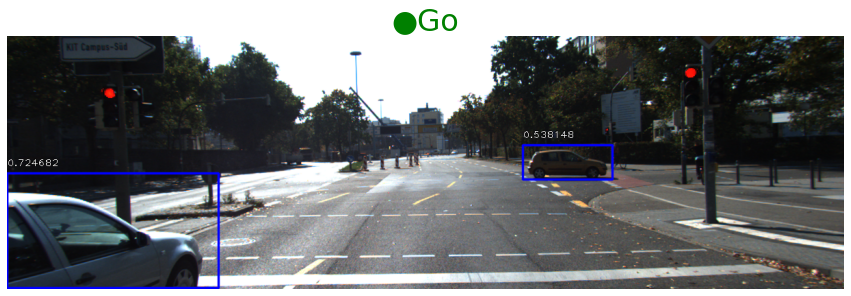

Go


In [16]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_3.png'
print(self_drive_assist(model=model,img_path=img_path))

## 3. 자율주행 시스템 평가하기
- ```test_system()```을 통해서 위에서 만든 함수를 평가해본다.
- 10장에 대해 go와 stop을 맞게 반환하는지 확인하고 100점 만점으로 평가한다.

In [17]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        pred = self_drive_assist(model=model, img_path=image_path, visualize=True)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

/home/aiffel-dj56/aiffel/object_detection/test_set/stop_1.png
[771.84827 154.94063 843.3286  312.92908]
[755.4298  181.09898 863.481   291.89008]


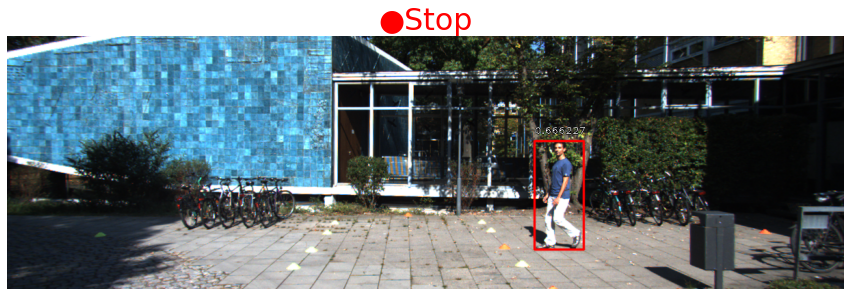

/home/aiffel-dj56/aiffel/object_detection/test_set/stop_2.png
[418.35068 158.16426 496.22113 330.61197]
[401.9811  179.23125 514.79565 300.85556]


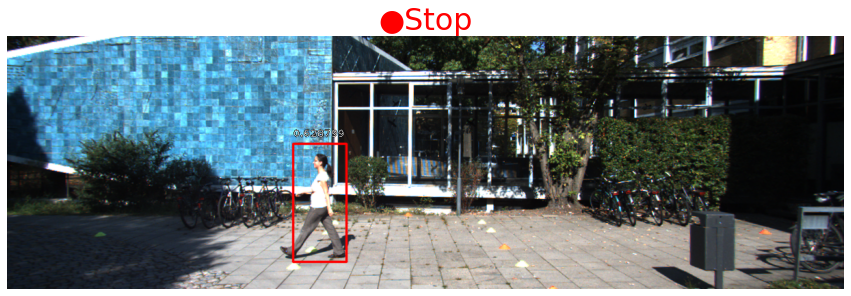

/home/aiffel-dj56/aiffel/object_detection/test_set/stop_3.png
[  0.      201.73524 309.28687 368.49615]
[754.53357 160.64844 885.3437  210.98314]
[743.0237  149.7525  912.3692  229.37886]


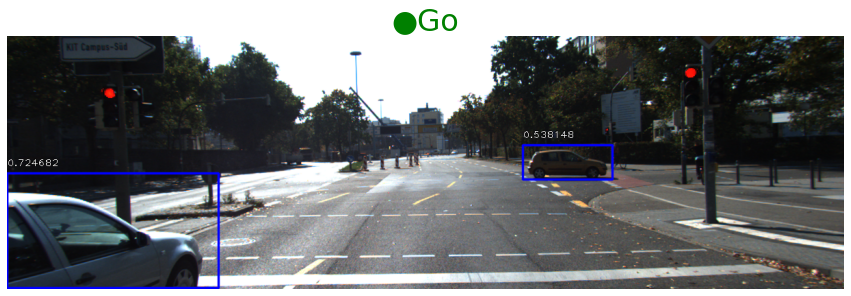

/home/aiffel-dj56/aiffel/object_detection/test_set/stop_4.png
[ 711.0995    90.45062 1103.9312   358.16895]
[ 37.806866 159.16924  373.27145  319.73572 ]


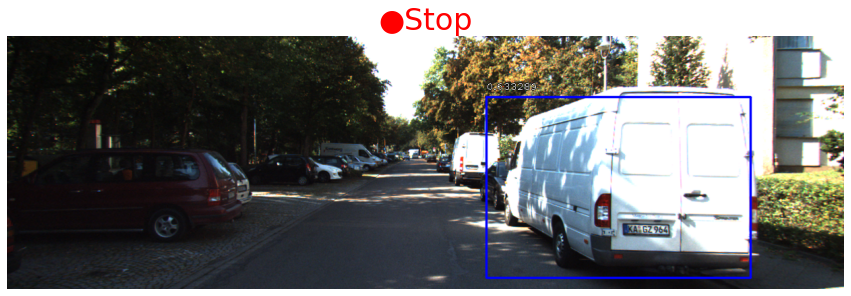

/home/aiffel-dj56/aiffel/object_detection/test_set/stop_5.png
[ 860.1585  175.0264 1241.0684  373.6249]


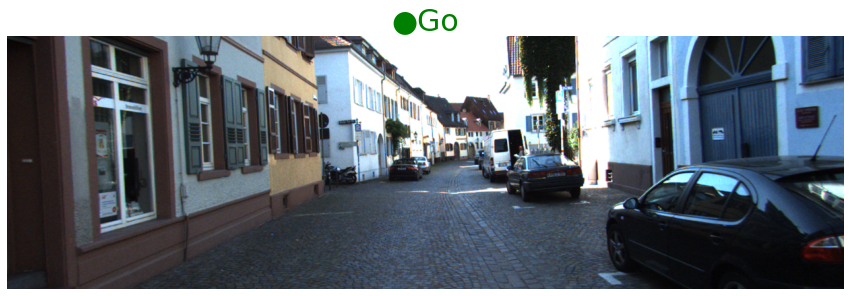

/home/aiffel-dj56/aiffel/object_detection/test_set/go_1.png
[594.34247 176.39368 626.1764  206.18208]
[193.73785 136.47726 350.70428 227.86914]


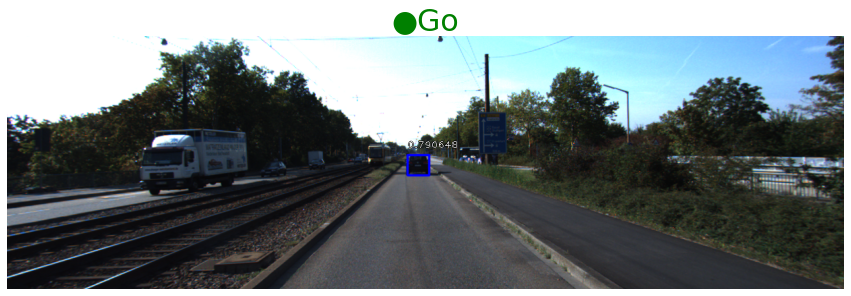

/home/aiffel-dj56/aiffel/object_detection/test_set/go_2.png
[627.1694  175.96967 668.13904 210.79971]
[514.4679  178.60309 567.50104 214.72308]


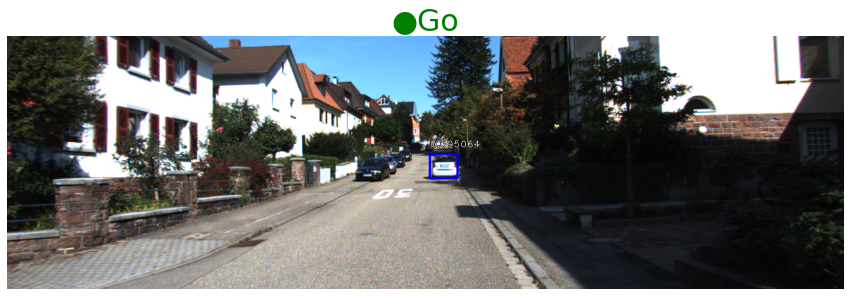

/home/aiffel-dj56/aiffel/object_detection/test_set/go_3.png
[805.9504  146.2277  882.83856 179.14305]


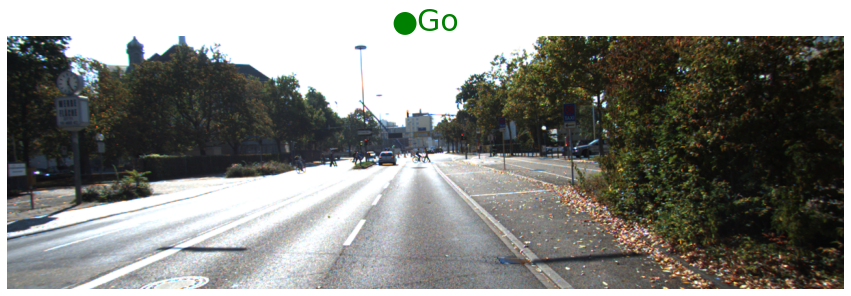

/home/aiffel-dj56/aiffel/object_detection/test_set/go_4.png
[695.283   170.38316 788.0872  253.75093]


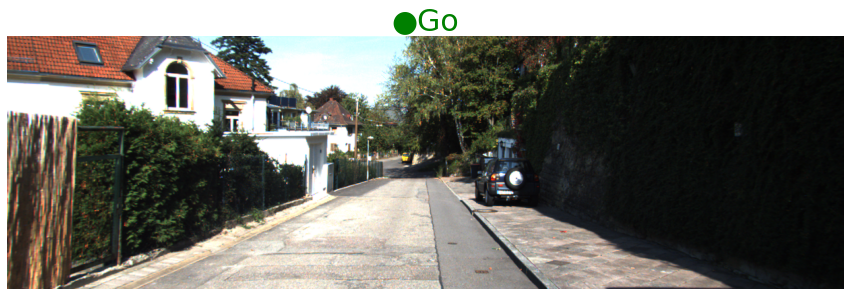

/home/aiffel-dj56/aiffel/object_detection/test_set/go_5.png
[ 19.560055 190.80336  220.02448  316.45193 ]


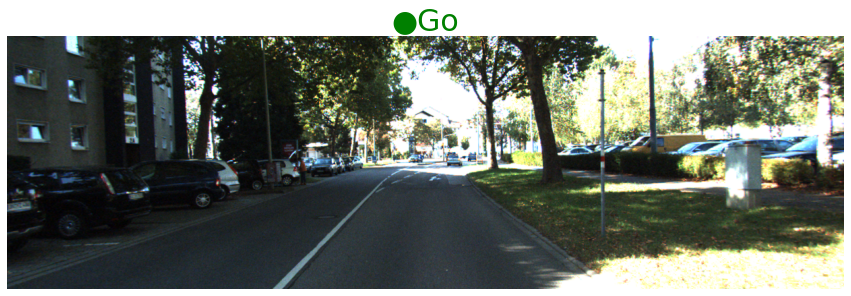

80점입니다.


In [18]:
test_system(self_drive_assist)

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

### 평가문항/상세기준

1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.  
KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.


2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.  
바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.


3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.  
테스트 수행결과 90% 이상의 정확도를 보였다.

## 결과 및 회고

width와 height의 개념과 설명을 다른 사람에게 듣고 코드를 보니 이해가 좀더 수월하였다. 
라벨과 실제 검출되는 이미지 박스가 학습을 할 때마다 다른 결과가 나와서 난감하였다. 최종으로 학습한 결과로 이미지 검출을 하였을 때, 라벨의 결과와 달리 도로변에 서있는 차가 검출되지 않은 경우가 발생하였다.  


실제 주행하는 운전자라고 생각하면 자연스럽게 주행(Go)를 해도 무방해 보이는 상황(Stop_3 경우)이지만, 학습결과에 따라 조금씩 차이가 난다면 자율주행 자동차를 신뢰하고 사람들이 100% 안전하게 이용하기 어려울 수도 있겠단 생각이 들었다.  
실제와 같진 않겠지만 자율 주행의 개념에 대해서 생각해 볼 수 있는 좋은 과제였다고 생각이 되었다.
실제 신호등과 같이 주행 신호를 표시할 수 있게 학습과 검출 기술에 부족한 점이 있는지 다시 살펴보야야 하겠다. 